In [1]:
from datetime import datetime, timedelta
import re

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud
import yfinance as yf
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import nltk
from nltk import pos_tag, word_tokenize

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/marklevin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/marklevin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Task 1: Descriptive Analytics
Here we load in the data, do some basic manipulation and deep dive into some visualizations and particularities. This part also shows our train of thought exploring the data.

In [2]:
df = pd.read_csv("data/Data_PCLab3_Twitter_Stock_Sentiment.csv")
print(df.shape)
df.head()

(5791, 2)


,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [3]:
# Remove punctuation that does not mark the end of a sentence
def remove_punct(text):
    no_punct = re.sub(r'[\,\-\/\:]', ' ', text)
    removed = re.sub(r'%', ' ', no_punct)
    return removed

def count_words(input_string):
    # Define a regex pattern to match one or more word characters (letters and numbers)
    pattern = r'\b\w+\b'

    # Find all non-overlapping matches in the input string
    words = re.findall(pattern, input_string)

    # Return the number of found words
    return len(words)

In [4]:
df['clean'] = df.apply(lambda x: remove_punct(x['Text']), axis=1)
df['word_count'] = df.apply(lambda x: count_words(x['clean']), axis=1)
df.head()

,Text,Sentiment,clean,word_count
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,20
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE. 55 return for the FEA GEED i...,17
2,user I'd be afraid to short AMZN - they are lo...,1,user I'd be afraid to short AMZN they are lo...,22
3,MNTA Over 12.00,1,MNTA Over 12.00,4
4,OI Over 21.37,1,OI Over 21.37,4


In [5]:
def get_stock_tickers(text):
    # Find all tickers in the text
    tickers = re.findall(r'(?:\b|[\$])[A-Z]{1,5}[0-9\.]*\b', text)
    # Clean up tickers by removing leading '$' and trailing punctuation
    tickers = [t.strip('$').rstrip('.,') for t in tickers]
    if len(tickers) == 0:
        return None
    elif len(tickers) == 1:
        return tickers[0]
    else:
        return ','.join(tickers)

In [6]:
df['ticker'] = df.apply(lambda x: get_stock_tickers(x['clean']), axis=1)
new_df = df.dropna()

def get_ticker_counts(df):
    df_exploded = df['ticker'].str.split(',').explode()
    ticker_counts = df_exploded.value_counts()
    return ticker_counts

ticker_counts = get_ticker_counts(new_df)
print(ticker_counts)

ticker
AAP      929
I        553
BAC      203
GOOG     196
NFX      118
        ... 
CAB        1
MTX        1
NEWS       1
SPEND      1
LIVE       1
Name: count, Length: 1722, dtype: int64


Here, we can see that the ticker \$AAP has 929 occurrences. This seems incorrect. AAP is a stock with a market cap of $3.3 billion and has decreased by 75% from its all-time high. It's not the kind of "sexy" stock that people would typically discuss, so the high occurrence could be due to the fact that this tweet dataset is a very small subset. Alternatively, it might be that people meant to refer to AAPL but misspelled it. Let's investigate this further by looking at some tweets:

In [7]:
df_matched = df[df['Text'].astype(str).str.contains("AAP")]
list(df_matched.tail(20)['clean'])

['AAP big time drop today on a day when market is up SPY',
 'GOOG in the 795 puts for .55  AAP is Crashing!',
 'GOOG and AAP  they want out for April earnings?',
 'AAP Support at 442ish and then gap fill below.   ',
 'user  AAP trying to bottom soon.  It may take 1 2 wks with a target low of 430 440.  ',
 'GOOG both FB and AAP down almost 2   trap door coming for the GOOG!',
 'AAP trying short here',
 'AAP please fasten yor seatbelts and enjoy the ride....',
 "AAP... you're going to have a tradable bounce on the heels of this post triangle breakdown.",
 'AAP China intensifies attacks on Apple   ',
 'Why are more people not talking about this China News??? Big Deal Imo! AAP China intensifies attacks on Apple  ',
 'AAP (daily) Three Black Crows and 50 (ema) teaming up**  ',
 'user  user  AAP (daily) Three Black Crows and 50 (ema) teaming up**  ',
 'AAP Full Stoch analysis yesterday   ',
 'AAP China news will Catch Fire this weekend just watch!',
 'Full Analysis Blog Post from yesterday W

Here we see that some tweets mention a stock price of around 450. This seems impossible with AAPL currently trading at around 225 dollars. However, in 2019, there was a 1:4 stock split, making this price possible. Additionally, we notice AAP being mentioned alongside the word "Apple" and "GOOG" (Google), indicating a probable typo. Therefore, we will change all occurrences of AAP to AAPL moving forward.

In [8]:
df['Text'] = df.apply(lambda x: x['Text'].replace("AAP", "AAPL"), axis=1)
df['clean'] = df.apply(lambda x: x['clean'].replace("AAP", "AAPL"), axis=1)

# Rerun the ticker retrieval
df['ticker'] = df.apply(lambda x: get_stock_tickers(x['clean']), axis=1)

Because we got errors for some keys later on (in looking up the industries), because they are misspelled, we will add them in specially:
- NFX -> NFLX
- RT -> RTX
- DDD -> DD

Just like the Apple ticker above.

> These are the only ones we found, so it is possible that there are a lot more...

In [9]:
df['Text'] = df.apply(lambda x: x['Text'].replace("NFX", "NFLX"), axis=1)
df['clean'] = df.apply(lambda x: x['clean'].replace("NFX", "NFLX"), axis=1)
df['Text'] = df.apply(lambda x: x['Text'].replace("RT", "RTX"), axis=1)
df['clean'] = df.apply(lambda x: x['clean'].replace("RT", "RTX"), axis=1)
df['Text'] = df.apply(lambda x: x['Text'].replace("DDD", "DD"), axis=1)
df['clean'] = df.apply(lambda x: x['clean'].replace("DDD", "DD"), axis=1)

df['ticker'] = df.apply(lambda x: get_stock_tickers(x['clean']), axis=1)

Let's also validate the stock tickers to ensure that we don't have any incorrect tickers. We'll use the list of S&P 500 tickers from the previous PC Lab.

In [10]:
# Get from the snp500 current composition the tickers.
snp_tickers = pd.read_csv("data/snp500_change.csv").iloc[2682]['tickers'].split(",")

# This is a small error and needs to be removed
assert "BIO" in snp_tickers
snp_tickers.remove("BIO")
assert "BIO" not in snp_tickers
found_tickers = list(get_ticker_counts(df).keys())


# Get the tickers that are also in snp_tickers from found_tickers
checked_tickers = [x for x in found_tickers if x in snp_tickers]
len(checked_tickers)

200

In [11]:
len(ticker_counts)

1722

Here we see out of the 1722 presumed tickers talked about in the tweets, only 200 occur in the S&P500. This is the only part we will focus on.

### Visualization
Now that we have retrieved the tickers that are being mentioned, it is interesting to look at the total value counts of the S&P500 stocks and the non-S&P500 stocks, let's compare their average occurrence count per ticker (we use average because there are 10x as many stocks outside of S&P500 found. 

In [12]:
counts = get_ticker_counts(df)
snp = sum([counts[x] for x in get_ticker_counts(df).keys() if x in checked_tickers])//len(checked_tickers)
no_snp = sum([counts[x] for x in get_ticker_counts(df).keys() if x not in checked_tickers])//(len(found_tickers)-len(checked_tickers))
print(f"There are {snp} average mentions of stocks inside of the S&P and {no_snp} average mentions of stocks outside of the S&P500")

There are 16 average mentions of stocks inside of the S&P and 4 average mentions of stocks outside of the S&P500


Although we thought this difference would be bigger, the fact that stocks inside of the S&P500 are mentioned more often makes sense. Now we get to the different visualizations:
- Words per tweet
- Distribution of industry of tickers mentioned (from S&P500)
- Amount of top 100 finance jargon mentioned (according to ChatGPT, but can give an insight of often used informal finance words)
- Average sentiment

#### Words per tweet

Text(0, 0.5, 'Frequency')

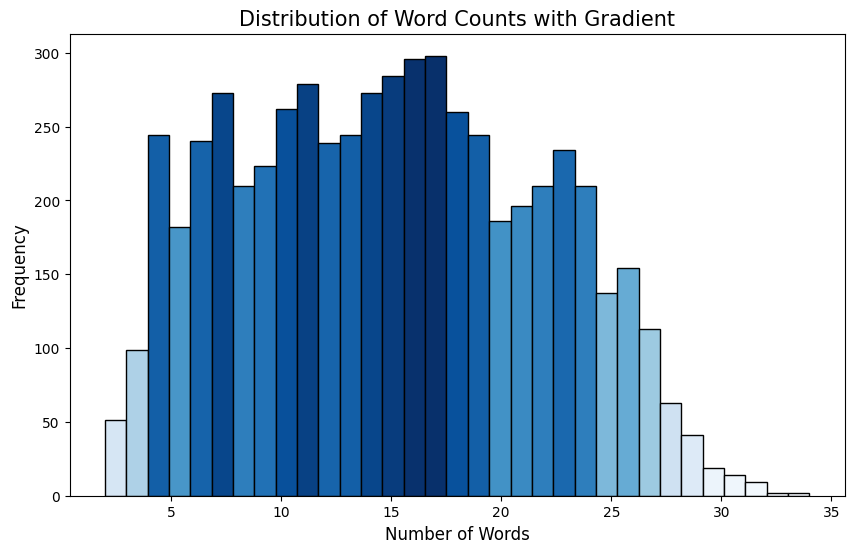

In [13]:
word_counts = df['word_count']

# Set the number of bins
bins = len(df['word_count'].value_counts().keys())

# Create a histogram
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the histogram data (values and bin edges)
counts, bin_edges, patches = ax.hist(word_counts, bins=bins, edgecolor='black')

# Normalize the bin counts to range between 0 and 1
norm = plt.Normalize(min(counts), max(counts))

# Apply a colormap (Blues) to each patch based on its bin height
for count, patch in zip(counts, patches):
    plt.setp(patch, 'facecolor', plt.cm.Blues(norm(count)))

# Add titles and labels
plt.title('Distribution of Word Counts with Gradient', fontsize=15)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)


The overall pattern of tweet length being consistent between 2 and 20 words appears normal. The number of words per tweet drops sharply after 25, as tweets have a maximum length limit. Below are some examples of 2-word tweets, which primarily consist of people expressing their bullish (positive) or bearish (negative) sentiments about a stock.

In [14]:
counter = 0
for i in range(0,df.shape[0]):
    if df.iloc[i]['word_count'] == 2:
        print(df.iloc[i]['clean'])
        counter += 1
    if counter == 10:
        break

MON   added
JNP   added
X   added
added APP
EBAY basing  
Short YHOO
AN breakout.
HT bearish
nice DE.
CHK squeezie   


#### Industries mentioned
We will now look at the industry data from last week, which industries are talked about most.

In [15]:
industry = pd.read_csv("data/market_cap.csv")
industry_lookup = dict(zip(industry['ticker'], industry['industry'])) 
# Add this temporary, to remove later
industry_lookup |= {"": ""}

In [16]:
industry['industry'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Utilities', 'Financials', 'Materials', 'Consumer Discretionary',
       'Real Estate', 'Communication Services', 'Consumer Staples',
       'Energy'], dtype=object)

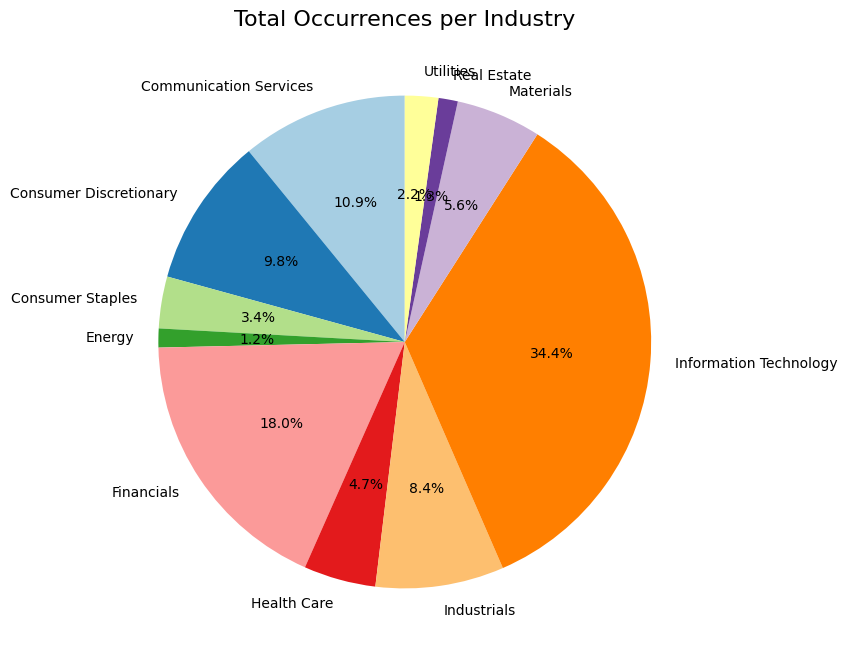

In [17]:
counts = get_ticker_counts(df)
tickers = counts.keys()

# Make the industry dataframe, by taking counts and looking up industry
df_indus = pd.DataFrame.from_dict([{"ticker": t, "counts": counts[t], "industry": industry_lookup[t]} for t in tickers if t in checked_tickers])
industry_data = df_indus.groupby('industry')['counts'].sum()

plt.figure(figsize=(8, 8))
plt.pie(industry_data, labels=industry_data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Total Occurrences per Industry', fontsize=16)

# Display the pie chart
plt.show()

Here we can see that people mostly talk about Information Technology and Financials (take up more than 50% of the total mentioned tickers). This is to be expected as these are part of the 'sexy stocks', such as TSLA, AAPL, GOOG and BAC. 

### Amount of top 100 Jargon Used
As said, we have asked ChatGPT to come up with informal finance words that could be used in tweets and see if they do occur and how often. We display that below.

In [18]:
finance_jargon = [
    'bullish', 'bearish', 'short', 'long', 'pump', 'dump', 'moon', 'whale', 'bagholder', 'FOMO',
    'FUD', 'HODL', 'paper hands', 'diamond hands', 'YOLO', 'stonks', 'dip', 'correction', 'rally',
    'crash', 'bubble', 'dead cat bounce', 'consolidation', 'breakout', 'support', 'resistance',
    'pullback', 'overbought', 'oversold', 'hot money', 'squeeze', 'short squeeze',
    'tendies', 'crash', 'tanking', 'meme stock', 'risk-on', 'risk-off', 'liquidation', 'profit-taking',
    'going long', 'going short', 'choppy', 'volatility', 'high-flyer', 'blue chip', 'penny stock',
    'swing trade', 'day trade', 'scalp', 'margin call', 'lockup', 'ATH', 'sell-off',
    'panic selling', 'bloodbath', 'bear trap', 'bull trap', 'hedging', 'divvy', 'leverage', 'margin',
    'liquidity crunch', 'double top', 'double bottom', 'all-time high', 'cup and handle',
    'pumping', 'bagging', 'dry powder', 'in the red', 'in the green', 'smart money', 'dumb money',
    'on the sidelines', 'taking profits', 'bottom fishing', 'buy the dip', 'breakout',
    'hold the line', 'overleveraged', 'cash cow', 'backdoor listing', 'SPAC', 'VIX', 'fear gauge',
    'unicorn', 'zombie company', 'safe haven', 'window dressing', 'underwater', 'parabolic', 
    'kick the can', 'ponzi', 'margin squeeze', 'soft landing', 'hard landing', 'degen', 'flip', 'grind'
]
len(finance_jargon)

100

In [19]:
def check_finance_jargon(current_dict, tweet, word_list):
    for word in word_list:
        current_dict[word] += len(re.findall(word, tweet))
    return current_dict

current_dict = {f"{x}": 0 for x in finance_jargon}

for i in range(df.shape[0]):
    current_dict = check_finance_jargon(current_dict, df.iloc[i]['clean'], finance_jargon)

sorted_dict = sorted(current_dict.items(), key=lambda item: item[1], reverse=True)
sorted_dict[:10]

[('short', 427),
 ('long', 312),
 ('breakout', 226),
 ('support', 119),
 ('resistance', 93),
 ('bullish', 86),
 ('pullback', 50),
 ('bearish', 39),
 ('consolidation', 33),
 ('rally', 32)]

Below we plot the most occurring terms and give a green colour for positive words, red for negative and grey for neutral words. 

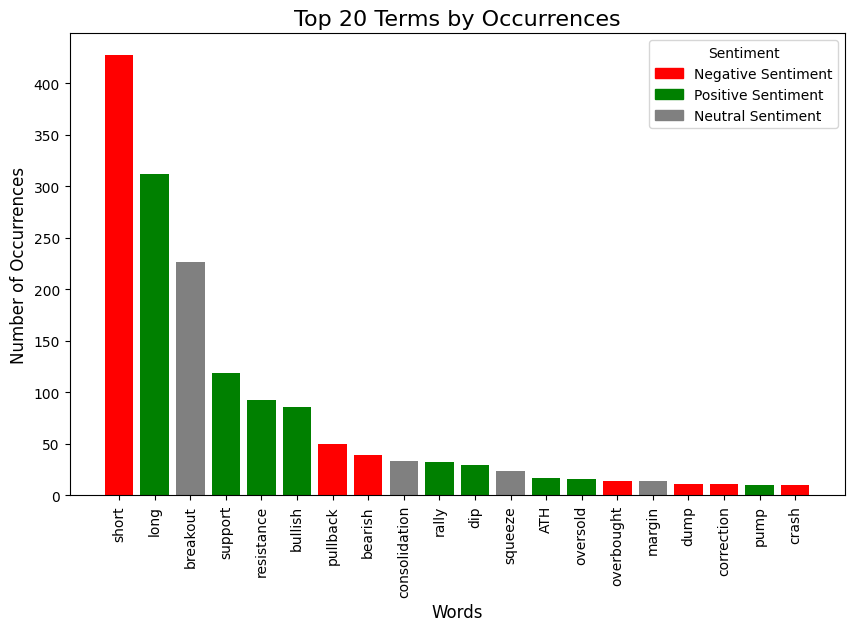

In [20]:
# Assuming sorted_dict is already defined and contains the word occurrences
keys = [item[0] for item in sorted_dict[:20]]
values = [item[1] for item in sorted_dict[:20]]

# Define the figure size
plt.figure(figsize=(10, 6))

# Define the colors for each bar corresponding to sentiment
c = ["red", "green", "grey", "green", "green", "green", "red", "red", "grey", "green", "green", 
     "grey", "green", "green", "red", "grey", "red", "red", "green", "red"]

# Create the bar plot with colors representing sentiment
plt.bar(keys, values, color=c)

# Create custom legend patches
red_patch = mpatches.Patch(color='red', label='Negative Sentiment')
green_patch = mpatches.Patch(color='green', label='Positive Sentiment')
grey_patch = mpatches.Patch(color='grey', label='Neutral Sentiment')

# Add legend to the plot
plt.legend(handles=[red_patch, green_patch, grey_patch], title="Sentiment")

# Set title and labels
plt.title('Top 20 Terms by Occurrences', fontsize=16)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [21]:
df.head()

,Text,Sentiment,clean,word_count,ticker
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,20,"XIDE,TIT,SOQ,PNK,CPW,BPZ,AJ"
1,user: AAPL MOVIE. 55% return for the FEA/GEED ...,1,user AAPL MOVIE. 55 return for the FEA GEED ...,17,"AAPL,MOVIE,FEA,GEED"
2,user I'd be afraid to short AMZN - they are lo...,1,user I'd be afraid to short AMZN they are lo...,22,"I,AMZN"
3,MNTA Over 12.00,1,MNTA Over 12.00,4,MNTA
4,OI Over 21.37,1,OI Over 21.37,4,OI


### Look at average sentiment for the tickers

In [22]:
exp_df = df.copy()
exp_df = exp_df
exp_df['ticker'] = exp_df['ticker'].str.split(',')

# Step 2: Explode the DataFrame to get separate rows for each ticker
exp_df = exp_df.explode('ticker')
exp_df = exp_df.loc[exp_df['ticker'].isin(snp_tickers)]
print(exp_df.shape)
exp_df = exp_df.dropna()
print(exp_df.shape)


(3383, 5)
(3383, 5)


In [23]:
grouped = exp_df.groupby('ticker')['Sentiment'].agg(['sum', 'count'])
grouped['weighted_sentiment'] = grouped['sum'] / grouped['count']
result = grouped.reset_index()
print(result[['ticker', 'weighted_sentiment']])

    ticker  weighted_sentiment
0        A            0.611650
1     AAPL            0.557589
2     ABBV            1.000000
3      ABT            1.000000
4     ADBE            0.166667
..     ...                 ...
195    WMB            1.000000
196    WMT            0.400000
197    WTW            0.000000
198   WYNN            0.583333
199    XOM            0.750000

[200 rows x 2 columns]


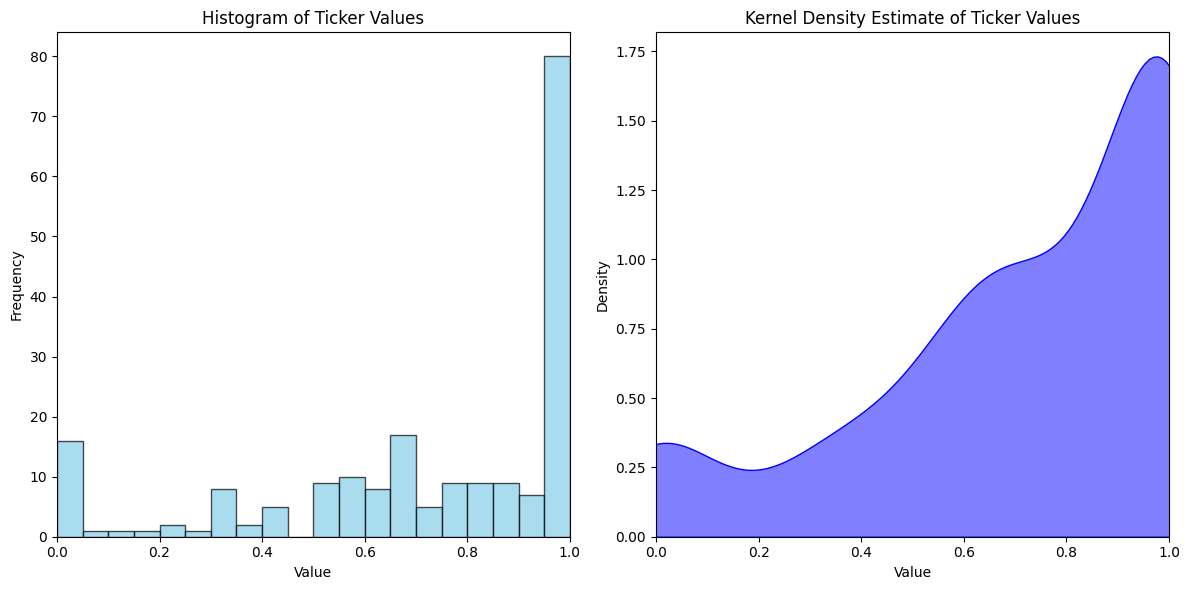

In [24]:
# Set up the figure and axis
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(result['weighted_sentiment'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Ticker Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim(0, 1)

plt.subplot(1, 2, 2)
sns.kdeplot(result['weighted_sentiment'], color='blue', fill=True, alpha=0.5)
plt.title('Kernel Density Estimate of Ticker Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

From this we can see that clearly most of the tickers being talked about are extremely positive. Note that this can be skewed because we are also looking at stocks that have only 1 occurrence in the data. Now that we have looked at some visualizations, let's go to the cleaning part, where we remove punctuation, stopwords and short words.

## Task 2: Cleaning and Visualization
Although we have visualized most of the plots in the previous step, we will do the following in this part:
1. Do some basic cleaning (basic as tweets are extremely dirty and thus cleaning is minimal, as all exceptions can have signal)
2. Try it out on sentence provided
3. Plot a word cloud for texts with positive and negative sentiment
4. Number of unique words

### Basic Cleaning and trying on sentence provided
For this we will remove the punctuation of sentences and other symbols. There are two symbols we will change:
- Exclamation mark: If this occurs in a word, we add the \<EMPHASIS\> tag to all of the words.
- Question mark: we will put in a \<QUESTION\> tag to all of the words, to allow the parser to see that there is some uncertainty in the tweet.

Otherwise the following changes will be made:
- Remove non-text characters: \[\\, \/, , +, =, #, %, $ \]
- Numbers will turn into \<NUM\> tags
- All tickers will be changed to \<TICKER\> to remove the preconditioned sentiment (what we saw above)
- Full cap words are set to also have the \<EMPHASIS\> tag.
- Remove small words as defined in the stop\_words list. Stop words and short words are removed interchangeably.

We will not make use of any cleaning packages as they are not made for this type of data. We will do everything from scratch to have full control. Other changes for cleaning will be done in the tokenization, when we add negativity to words if they follow a not and more emphasis (like we did here) if the word follows really or very.

In [25]:
new_df['ticker'] = df['ticker'].str.split(',')
new_df = new_df.explode('ticker')
unique_tickers = list(new_df.ticker.unique())

/var/folders/tq/wkz757zn55nfttdc074n4hv80000gn/T/ipykernel_73618/3390972518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['ticker'] = df['ticker'].str.split(',')


For the stop words we could not find a specific spot words list that would work with Finance (things such as up and down that are usually stop words are not non-sentimental in the case of finance). We thus asked a LLM to provide us with 200 words that would be classified as non-sentimental for finance and picked the ones we found are neutral

In [26]:
stop_words = [
    "I", "he", "him", "her", "she", "they", "them", "we", "us",
    "the", "is", "in", "to", "and", "a", "of", "it", "that", "you",
    "for", "on", "with", "as", "are", "this", "by", "be", "at", "have",
    "from", "or", "but", "an", "we", "they", "all", "can", "more",
    "if", "about", "do", "my", "will", "there", "when", "who", "their", 
    "what", "out", "so", "up", "just", "like", "also", "each", 
    "many", "such", "another", "year", "two", "one", "first", 
    "last", "time", "after", "before", "during", "this", "that", 
    "between", "while", "need", "even", 
    "back", "go", "place", "https", "user", "today", "stock"
]
len(stop_words)


def remove_ticker(unique_tickers, ticker):
    try:
        unique_tickers.remove(ticker)
    except:
        pass
    return unique_tickers

for i in [None, '', " ", "I", "AI"]:
    unique_tickers = remove_ticker(unique_tickers, i)

In [27]:
class Cleaner:
    def __init__(self, stop_words, unique_tickers=unique_tickers):
        self.stop_words = stop_words
        self.unique_tickers = unique_tickers

    @staticmethod
    def question_mark(tweet):
        question = False
        for word in tweet.split(" "):
            if "?" in word:
                question = True
        if question:
            return " ".join([x+"<question>" for x in tweet.split(" ")])
        else:
            return tweet
    
    @staticmethod
    def exclamation_mark(tweet):
        words = []
        emphasis = False
        for word in tweet.split(" "):
            if "!" in word and len(word.replace("!", "")) != 0:
                words.append(f"{word}_<emphasis>")
            else:
                words.append(word)
        return " ".join(words)

    @staticmethod
    def number_remove(tweet):
        return re.sub('[0-9]+', '<num>', tweet)


    def replace_tickers(self, tweet):
        for tick in self.unique_tickers:
            if not tick:
                continue
            tweet = re.sub(r'\b'+tick+r'\b', '&&&', tweet)

        # Do not change it immediately because otherwise tickers such as KER would mess it up
        return tweet.replace("&&&", "<ticker>")
                           
    @staticmethod
    def add_emphasis(tweet):
        sent = []
        for word in tweet.split(" "):
            if not word:
                # This is a space
                continue
            if word.isupper() and len(word) > 2:
                sent.append(f"{word}_<emphasis>")
            else:
                sent.append(word)
        return " ".join(sent)


    @staticmethod
    def remove_special_characters(tweet):
        special_chars = "\/,<>()#$%^@&|}{:;'\"."
        for special in special_chars:
            tweet = tweet.replace(special, " ")
        return tweet


    def remove_stop_words(self, tweet):
        return_tweet = []
        for word in tweet.split(" "):
            if word not in self.stop_words:
                return_tweet.append(word)
        return " ".join(return_tweet)

    
    def clean(self, tweet):
        tweet = self.remove_special_characters(tweet)
        tweet = self.replace_tickers(tweet)
        tweet = self.number_remove(tweet)
        tweet = self.add_emphasis(tweet)
        
        tweet = self.exclamation_mark(tweet)
        tweet = self.question_mark(tweet)
        tweet = self.remove_stop_words(tweet)
        # Remove double spaces
        tweet = tweet.replace("!", "")
        tweet = tweet.lower()
        tweet = " ".join(x for x in tweet.split(" ") if len(x) > 1)
        return re.sub(r'\s+', ' ', tweet).strip()

cleaner = Cleaner(stop_words)

Check it on the sentence provided, the advanced behaviour of seeing the emoji ;) is too advanced and occurs too little. The ...!! also will occur not often so these edge cases are not added.

In [28]:
cleaner.clean("$I love AI & Machine learning applied to Finance...!! ;)")

'love ai machine learning applied finance'

In [29]:
df['processed'] = df.apply(lambda x: cleaner.clean(x['clean']), axis=1)

Now we are going to visualize the wordclouds with the words in positive and negative. Of course we do some small improvements, such as:
- Removing tickers
- Removing exclamation and question
- Removing numbers

(-0.5, 799.5, 399.5, -0.5)

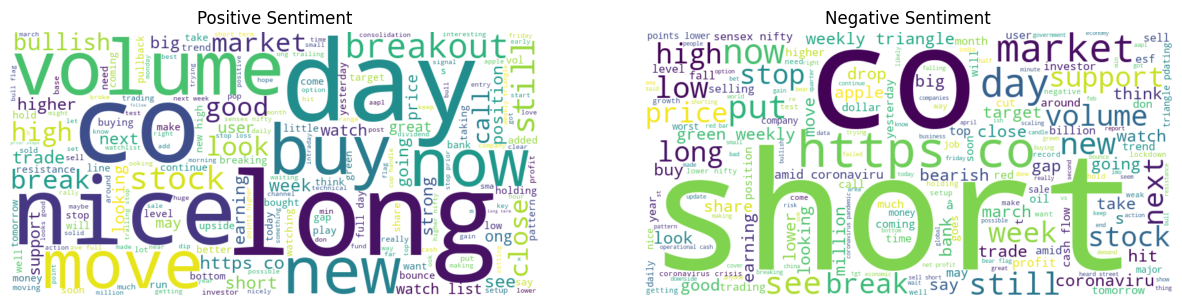

In [30]:
replacing = ["<ticker>", "<num>", "<question>", "<emphasis>", "_"]

def replace_parts(text, repl):
    return text.replace(repl, "")



pos = " ".join(df[df['Sentiment'] == 1]['processed'].values)
neg = " ".join(df[df['Sentiment'] == 0]['processed'].values)


for repl in replacing:
    pos = replace_parts(pos, repl)
    neg = replace_parts(neg, repl)


wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(neg)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title('Positive Sentiment')
axes[0].axis('off')

axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title('Negative Sentiment')
axes[1].axis('off')

Here we see some words that we expected. For the positive we see:
- long
- nice
- bullish
- buy
- breakout

These are all words that describe a positive momentum or side of a stock. We also saw these in the most occurring words and this means that these words have a lot of signal in determining whether a stock has positive sentiment. However we also see short as a word, which is unexpected. This could happen because someone is talking about two stocks at the same time or because he uses the word in a different context such as he is going to buy the stock in a short time. A last possibility could be that it is sarcasm or irony.

##### Negative
For negative wordcloud we see very big: short. This is the principal word that shows that people think the stock is going down. They say stuff like: I will short the stock or short now. We can also see the word put, which means buying the right but not the obligation to sell a stock later in time (opposite of a call option). What is however strange is that long (going long on a stock is to buy it where you think the price will go up) has around the same word size.

----
Two other interesting points:
- Apple is seen as Negative as it is in the negative sentiment
- Topics such as coronavirus, oil and lockdown can be found in the negative wordcloud, showing that people like to talk more about negative shocks than positive shocks. 

## Task 3. Sentiment analysis

Here we use the TensorFlow/Keras tokenizer and build a simple LSTM model on top of it.

In [31]:
texts = df['processed'].to_list()
labels = df['Sentiment'].to_list()

# Tokenize the text
max_words = 1000  # maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Padding sequences
max_sequence_length = max([len(seq) for seq in sequences])  # maximum length of each sentence
data = pad_sequences(sequences, maxlen=max_sequence_length)

# Split into train and test datasets 
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)

# Build a simple LSTM model
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))  # output layer for binary classification

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, np.array(y_train), epochs=5, batch_size=16, validation_data=(X_test, np.array(y_test)))

# Predict and evaluate on the test set
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)

Epoch 1/5


/Users/marklevin/.pyenv/versions/3.11.5/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


326/326 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6447 - loss: 0.6455 - val_accuracy: 0.7379 - val_loss: 0.5053
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7671 - loss: 0.4754 - val_accuracy: 0.7466 - val_loss: 0.5062
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8067 - loss: 0.4122 - val_accuracy: 0.7448 - val_loss: 0.5307
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8257 - loss: 0.3939 - val_accuracy: 0.7586 - val_loss: 0.5179
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8364 - loss: 0.3750 - val_accuracy: 0.7379 - val_loss: 0.5441
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


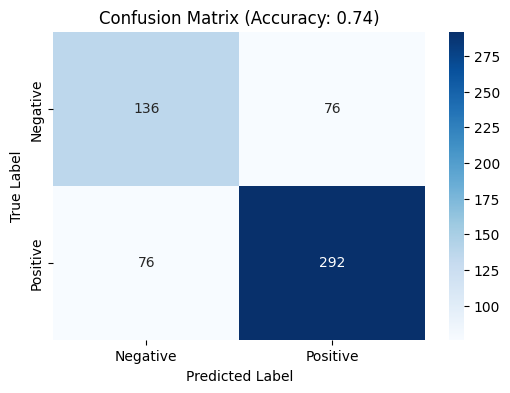

Accuracy: 0.74


In [32]:
accuracy = accuracy_score(y_test, y_pred_class)

conf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f"Accuracy: {accuracy:.2f}")

## Task 4. Sentiment analysis

We used sentence transformers to create the text embeddings, which was done on Colab due to the computational complexity.

In [ ]:
# this part was done on colab due to the computational complexity.
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/sentence-t5-base")

data = pd.read_csv('data/Data_PCLab3_Twitter_Stock_Sentiment.csv')

n_elements = len(data['Text'])
n_train = int(n_elements*0.1)
test = pd.DataFrame({'Text': list(data['Text'])[:n_train], 'Sentiment': list(data['Sentiment'])[:n_train]})
train = pd.DataFrame({'Text': list(data['Text'])[n_train:], 'Sentiment': list(data['Sentiment'])[n_train:]})

test_vectors =  model.encode(list(test['Text']))
train_vectors = model.encode(list(train['Text']))

test['embeddings'] = test_vectors.tolist()
train['embeddings'] = train_vectors.tolist()
test.to_csv('test.csv')
train.to_csv('train.csv')

In [33]:
def redefine(elem):
    elem = elem[1:-1]
    elem = elem.split()
    final = []
    for i in elem:
        i = i.replace(',', '')
        final.append(float(i))
    return final



test = pd.read_csv('data/test.csv')
test['embeddings'] = test['embeddings'].apply(redefine)
train = pd.read_csv('data/train.csv')
train['embeddings'] = train['embeddings'].apply(redefine)

train['Sentiment'] = train['Sentiment'].apply(lambda x: int(x))  # apply Python's int
train['Sentiment'] = train['Sentiment'].astype('object') 

test['Sentiment'] = test['Sentiment'].apply(lambda x: int(x))  # apply Python's int
test['Sentiment'] = test['Sentiment'].astype('object') 

Now we build a classifier. We found that the best performing one was XGBoost.

In [34]:
dtrain = xgb.DMatrix(list(train['embeddings']) , label=train['Sentiment'])
dtest = xgb.DMatrix(list(test['embeddings']), label=test['Sentiment'])

params = {
    'objective': 'multi:softmax',  
    'num_class': 2,  
    'max_depth': 3,  
    'learning_rate': 0.1,  
    'n_estimators': 100,  
    'eval_metric': 'mlogloss'  
}


num_boost_round=100

model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, objective='multi:softmax', num_class=3)

# Train the model using X_train and y_train
evals = [(dtrain, 'train'), (dtest, 'test')]

# Train the model
bst = xgb.train(params, dtrain, num_boost_round, evals=evals)


y_pred = bst.predict(dtest)

[0]	train-mlogloss:0.67150	test-mlogloss:0.66925
[1]	train-mlogloss:0.65179	test-mlogloss:0.64739
[2]	train-mlogloss:0.63554	test-mlogloss:0.63031
[3]	train-mlogloss:0.62074	test-mlogloss:0.61564


/Users/marklevin/.pyenv/versions/3.11.5/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:20:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	train-mlogloss:0.60722	test-mlogloss:0.60116
[5]	train-mlogloss:0.59499	test-mlogloss:0.58813
[6]	train-mlogloss:0.58417	test-mlogloss:0.57573
[7]	train-mlogloss:0.57421	test-mlogloss:0.56704
[8]	train-mlogloss:0.56536	test-mlogloss:0.55815
[9]	train-mlogloss:0.55637	test-mlogloss:0.55186
[10]	train-mlogloss:0.54908	test-mlogloss:0.54365
[11]	train-mlogloss:0.54215	test-mlogloss:0.53968
[12]	train-mlogloss:0.53528	test-mlogloss:0.53460
[13]	train-mlogloss:0.52924	test-mlogloss:0.53047
[14]	train-mlogloss:0.52337	test-mlogloss:0.52651
[15]	train-mlogloss:0.51770	test-mlogloss:0.52248
[16]	train-mlogloss:0.51230	test-mlogloss:0.51821
[17]	train-mlogloss:0.50724	test-mlogloss:0.51454
[18]	train-mlogloss:0.50210	test-mlogloss:0.51004
[19]	train-mlogloss:0.49760	test-mlogloss:0.50752
[20]	train-mlogloss:0.49316	test-mlogloss:0.50344
[21]	train-mlogloss:0.48913	test-mlogloss:0.50063
[22]	train-mlogloss:0.48533	test-mlogloss:0.49847
[23]	train-mlogloss:0.48172	test-mlogloss:0.49609
[24]	t

Accuracy: 79.62%


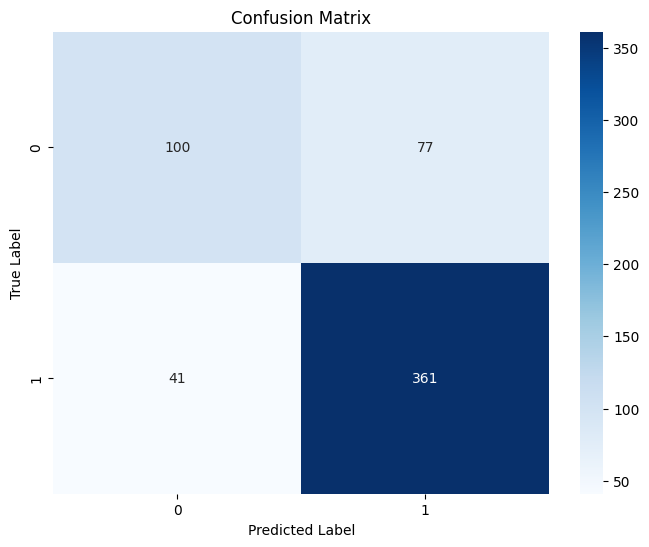

In [35]:
accuracy = accuracy_score(list(test['Sentiment']), y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(list(test['Sentiment']), y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The accuracy of the classifier was nearly 80%, with 13% false positives and 7% false negatives. In the given sample, there were almost twice as many positive sentiment elements as negative ones. We'll try to improve the result using the FinBERT model.

In [35]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

In [ ]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

Using FinBERT, we generated labels based on the content of each tweet.

In [ ]:
text = df['Text']
labels = []
for i in tqdm(text):
    label =  nlp(i)
    labels.append(label)
df['FinBert_sentiment'] = labels

In [36]:
#df.to_csv('data_predictions.csv')
df = pd.read_csv('data/data_predictions.csv')

In [37]:
import ast
def label_def(elem):
    elem = elem[1:-1]
    elem = ast.literal_eval(elem)
    return elem

def score_set(d):
    if d['label'] == 'Positive':
        return 1
    elif d['label'] == 'Negative':
        return 0
    else:
        return 1
    

df['FinBert_sentiment'] = df['FinBert_sentiment'].apply(label_def)
df['label'] = df['FinBert_sentiment'].apply(score_set)

Accuracy: 68.33%


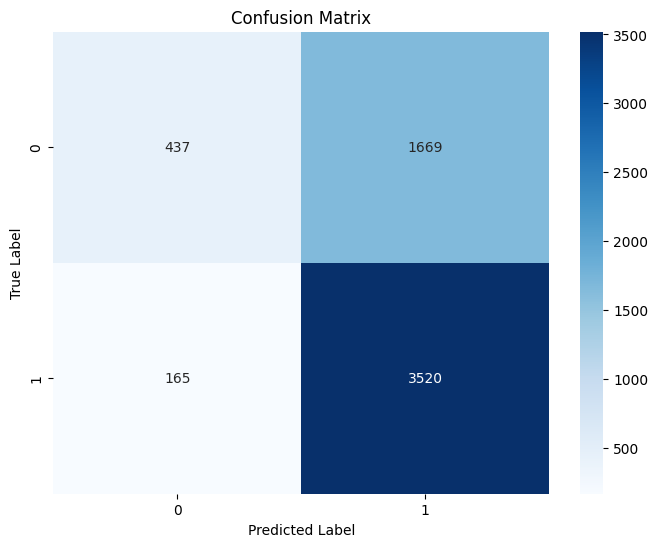

In [38]:
accuracy = accuracy_score(list(df['Sentiment']), list(df['label']))
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(list(df['Sentiment']), list(df['label']))


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In this case, we found better performance by changing the neutral labels (produced by FinBERT) to positive, achieving 68% accuracy. Setting them to negative yielded only 50% accuracy. We believe this lower result was due to the model also accounting for neutral elements.

## Task 5. Measuring media attention

In [39]:
import requests
from bs4 import BeautifulSoup

In [40]:
df = pd.read_csv('data/Data_PCLab3_Twitter_Stock_Sentiment.csv')

In [41]:
# pd.set_option('display.max_colwidth', None)
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [42]:
snp_tickers

['A',
 'AAL',
 'AAPL',
 'ABBV',
 'ABNB',
 'ABT',
 'ACGL',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALL',
 'ALLE',
 'AMAT',
 'AMCR',
 'AMD',
 'AME',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'ANET',
 'ANSS',
 'AON',
 'AOS',
 'APA',
 'APD',
 'APH',
 'APTV',
 'ARE',
 'ATO',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXON',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BALL',
 'BAX',
 'BBWI',
 'BBY',
 'BDX',
 'BEN',
 'BF.B',
 'BG',
 'BIIB',
 'BK',
 'BKNG',
 'BKR',
 'BLDR',
 'BLK',
 'BMY',
 'BR',
 'BRK.B',
 'BRO',
 'BSX',
 'BWA',
 'BX',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CARR',
 'CAT',
 'CB',
 'CBOE',
 'CBRE',
 'CCI',
 'CCL',
 'CDNS',
 'CDW',
 'CE',
 'CEG',
 'CF',
 'CFG',
 'CHD',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COO',
 'COP',
 'COR',
 'COST',
 'CPAY',
 'CPB',
 'CPRT',
 'CPT',
 'CRL',
 'CRM',
 'CRWD',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTLT',
 'C

In [43]:
def count_tweets():
    # Initialize the snp_counts dataframe
    snp_counts = pd.DataFrame({'ticker': snp_tickers})
    snp_counts['total_tweets'] = 0
    snp_counts['negative_tweets'] = 0
    snp_counts['positive_tweets'] = 0

    # Iterate through the tweets dataframe
    for _, row in df.iterrows():
        text = row['Text']
        for idx, ticker in snp_counts['ticker'].items():
            # Create a regex pattern that matches the whole word ticker
            pattern = r'\b{}\b'.format(re.escape(ticker))
            if re.search(pattern, text):
                if row['Sentiment'] == 0:
                    snp_counts.at[idx, 'negative_tweets'] += 1
                elif row['Sentiment'] == 1:
                    snp_counts.at[idx, 'positive_tweets'] += 1

    snp_counts['total_tweets'] = snp_counts['negative_tweets'] + snp_counts['positive_tweets']

    return snp_counts

In [44]:
snp_counts = count_tweets()

In [45]:
snp_counts.head()

,ticker,total_tweets,negative_tweets,positive_tweets
0,A,101,40,61
1,AAL,0,0,0
2,AAPL,0,0,0
3,ABBV,1,0,1
4,ABNB,0,0,0


In [46]:
for _, row in snp_counts.iterrows():
    print(f"{row['ticker']}: {row['total_tweets']} tweets, {row['negative_tweets']} tweets, {row['positive_tweets']} tweets")

A: 101 tweets, 40 tweets, 61 tweets
AAL: 0 tweets, 0 tweets, 0 tweets
AAPL: 0 tweets, 0 tweets, 0 tweets
ABBV: 1 tweets, 0 tweets, 1 tweets
ABNB: 0 tweets, 0 tweets, 0 tweets
ABT: 5 tweets, 0 tweets, 5 tweets
ACGL: 0 tweets, 0 tweets, 0 tweets
ACN: 0 tweets, 0 tweets, 0 tweets
ADBE: 6 tweets, 5 tweets, 1 tweets
ADI: 1 tweets, 0 tweets, 1 tweets
ADM: 5 tweets, 0 tweets, 5 tweets
ADP: 0 tweets, 0 tweets, 0 tweets
ADSK: 3 tweets, 0 tweets, 3 tweets
AEE: 7 tweets, 3 tweets, 4 tweets
AEP: 3 tweets, 1 tweets, 2 tweets
AES: 0 tweets, 0 tweets, 0 tweets
AFL: 0 tweets, 0 tweets, 0 tweets
AIG: 15 tweets, 8 tweets, 7 tweets
AIZ: 1 tweets, 0 tweets, 1 tweets
AJG: 0 tweets, 0 tweets, 0 tweets
AKAM: 5 tweets, 3 tweets, 2 tweets
ALB: 0 tweets, 0 tweets, 0 tweets
ALGN: 0 tweets, 0 tweets, 0 tweets
ALL: 0 tweets, 0 tweets, 0 tweets
ALLE: 0 tweets, 0 tweets, 0 tweets
AMAT: 1 tweets, 0 tweets, 1 tweets
AMCR: 0 tweets, 0 tweets, 0 tweets
AMD: 6 tweets, 2 tweets, 4 tweets
AME: 0 tweets, 0 tweets, 0 tweets


In [47]:
display(snp_counts.sort_values('total_tweets', ascending=False).head())
display(snp_counts.sort_values('negative_tweets', ascending=False).head())
display(snp_counts.sort_values('positive_tweets', ascending=False).head())

,ticker,total_tweets,negative_tweets,positive_tweets
51,BAC,199,48,151
210,GOOG,188,70,118
32,AMZN,105,47,58
0,A,101,40,61
215,GS,67,21,46


,ticker,total_tweets,negative_tweets,positive_tweets
210,GOOG,188,70,118
51,BAC,199,48,151
32,AMZN,105,47,58
0,A,101,40,61
78,CAT,47,36,11


,ticker,total_tweets,negative_tweets,positive_tweets
51,BAC,199,48,151
210,GOOG,188,70,118
0,A,101,40,61
32,AMZN,105,47,58
215,GS,67,21,46


The high number of 'A' occurrences is likely due to its use as an article, not a ticker symbol. The company with this ticker is small and rarely mentioned, so most 'A' entries are unrelated to it. Let's investigate tweets mentioning it to confirm our suspicions. 

In [48]:
for _, row in df.iterrows():
    text = row['Text']
    pattern = r'\b{}\b'.format(re.escape('A'))
    if re.search(pattern, text):
        print(row['Text'])

Very bullish on market  also talked trends for SCTY OST ANGI FIO  PANW A JCP P YEP MNST GPN on show.
A quiet Carl Icahn = Bullish.  NFX shorts should be paranoid on every close as they will get acquired.  Think aapl, msft, amzn, fb
HB.A - ong  73.67. Trailing Stop  71.92 from 3 prior Stops of 70.86, 68.64 and 62.41 -  
A few I'm not holding but will check out. user: Bullish MACD cross: BBG COP ENI EOG JEC IG SFY XE XOP
AMZN the data company, not the retailer.  A new post by me.   
A Tale of Two Stocks  AAP GOOG SPY QQQ
must follow the young man user: AMZN the data company, not the retailer.  A new post by me.   
744.96 IS A great level for a close on GOOG
TSO option trader buys 10k of the Feb 40P for 1.60. A 1.6 million bet stock will be below 40 by Feb exp. Could be hedge too. OI is 544
TAB I like this one, down for no real reason, new contracts picking up slack, 2013 is about 'small cell' tech, & Software-As-A-Service!!!
A doji like candle close today on F may signify possible retrac

It seems we were right. Let's modify our function to include 'A' only if it's not used as an article. We'll use the POS tagger from the `nltk` module to achieve this.

In [49]:
def count_tweets_v2():
    # Initialize the snp_counts dataframe
    snp_counts = pd.DataFrame({'ticker': snp_tickers})
    snp_counts['total_tweets'] = 0
    snp_counts['negative_tweets'] = 0
    snp_counts['positive_tweets'] = 0

    # Iterate through the tweets dataframe
    for _, row in df.iterrows():
        text = row['Text']
        words = word_tokenize(text)
        pos_tags = pos_tag(words)  # Get POS tags for the words in the text
        
        for idx, ticker in snp_counts['ticker'].items():
            # Create a regex pattern that matches the whole word ticker
            pattern = r'\b{}\b'.format(re.escape(ticker))
            
            if re.search(pattern, text):
                # Find the index of the ticker in the tokenized list
                ticker_indices = [i for i, word in enumerate(words) if re.fullmatch(pattern, word)]
                
                # Check if the ticker is not used as a POS tag for an article (e.g., 'A' being used as an indefinite article)
                valid_ticker = any(pos_tags[i][1] not in ('DT') for i in ticker_indices) if ticker_indices else False
                
                if valid_ticker:
                    if row['Sentiment'] == 0:
                        snp_counts.at[idx, 'negative_tweets'] += 1
                    elif row['Sentiment'] == 1:
                        snp_counts.at[idx, 'positive_tweets'] += 1

    # Calculate the total number of tweets for each ticker
    snp_counts['total_tweets'] = snp_counts['negative_tweets'] + snp_counts['positive_tweets']

    return snp_counts

In [50]:
snp_counts = count_tweets_v2()

In [51]:
display(snp_counts.sort_values('total_tweets', ascending=False).head())
display(snp_counts.sort_values('negative_tweets', ascending=False).head())
display(snp_counts.sort_values('positive_tweets', ascending=False).head())

,ticker,total_tweets,negative_tweets,positive_tweets
51,BAC,197,48,149
210,GOOG,187,70,117
32,AMZN,104,46,58
215,GS,67,21,46
78,CAT,47,36,11


,ticker,total_tweets,negative_tweets,positive_tweets
210,GOOG,187,70,117
51,BAC,197,48,149
32,AMZN,104,46,58
78,CAT,47,36,11
215,GS,67,21,46


,ticker,total_tweets,negative_tweets,positive_tweets
51,BAC,197,48,149
210,GOOG,187,70,117
32,AMZN,104,46,58
215,GS,67,21,46
467,V,46,4,42


In [52]:
snp_counts[snp_counts['ticker'] == 'A']

,ticker,total_tweets,negative_tweets,positive_tweets
0,A,31,12,19
